In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

## End-to-end batched inference

If all prompts are available in advance, it is possible to run SAM directly in an end-to-end fashion. This also allows batching over images.

In [7]:
#number list way
import os
import cv2
from pathlib import Path

image_list = []
path = '../../BAM-main/visual/query/'

num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
print('num_files',num_files)



for i in range(num_files):
    image_t = cv2.imread(path + str(i) + '.jpg', cv2.COLOR_BGR2RGB)
    image_t = cv2.cvtColor(image_t, cv2.COLOR_BGR2RGB)
    image_t = cv2.resize(image_t, (500, 500))
    image_list.append(image_t)

fssmask_list = []
for i in range(num_files):
    mask_t = cv2.imread('../../BAM-main/visual/output/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
    mask_t = cv2.resize(mask_t, (500, 500))
    fssmask_list.append(mask_t)

gt_list = []
for i in range(num_files):
    mask_gt = cv2.imread('../../BAM-main/visual/label/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
    mask_gt2 = cv2.imread('../../BAM-main/visual/label2/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
    mask_gt = cv2.resize(mask_gt, (500, 500))
    mask_gt2 = cv2.resize(mask_gt2, (500, 500))
    mask_final = cv2.absdiff(mask_gt2, mask_gt) 
    # cv2.imwrite('visual/new/' + str(i)+'.jpg', mask_final)
    gt_list.append(mask_final)

maskpt_list = []
for i in range(num_files):
    maskpt = torch.load('../../BAM-main/visual/outputpt/' + str(i)  + '.pt')
    maskpt_list.append(maskpt)

# gt_list_base = []
# for i in range(num_files):
#     mask_gt = cv2.imread('../../Boosting/visual_dataset/res50-split0/label/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
#     mask_gt2 = cv2.imread('../../Boosting/visual_dataset/res50-split0/label2/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
#     mask_gt = cv2.resize(mask_gt, (500, 500))
#     mask_gt2 = cv2.resize(mask_gt2, (500, 500))
#     mask_final = cv2.absdiff(mask_gt2, mask_gt) 
#     # cv2.imwrite('visual/new/' + str(i)+'.jpg', mask_final)
#     gt_list_base.append(mask_gt)

# gt_list_l = []
# for i in range(num_files):
#     mask_gt = cv2.imread('../../Boosting/visual_dataset/res50-split0/label/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
#     mask_gt2 = cv2.imread('../../Boosting/visual_dataset/res50-split0/label2/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
#     mask_gt = cv2.resize(mask_gt, (500, 500))
#     mask_gt2 = cv2.resize(mask_gt2, (500, 500))
#     mask_final = cv2.absdiff(mask_gt2, mask_gt) 
#     # cv2.imwrite('visual/new/' + str(i)+'.jpg', mask_final)
#     gt_list_l.append(mask_gt2)
print(len(fssmask_list))
print(len(gt_list))
# print(len(gt_list_base))
print(len(image_list))

num_files 1000
1000
1000
1000


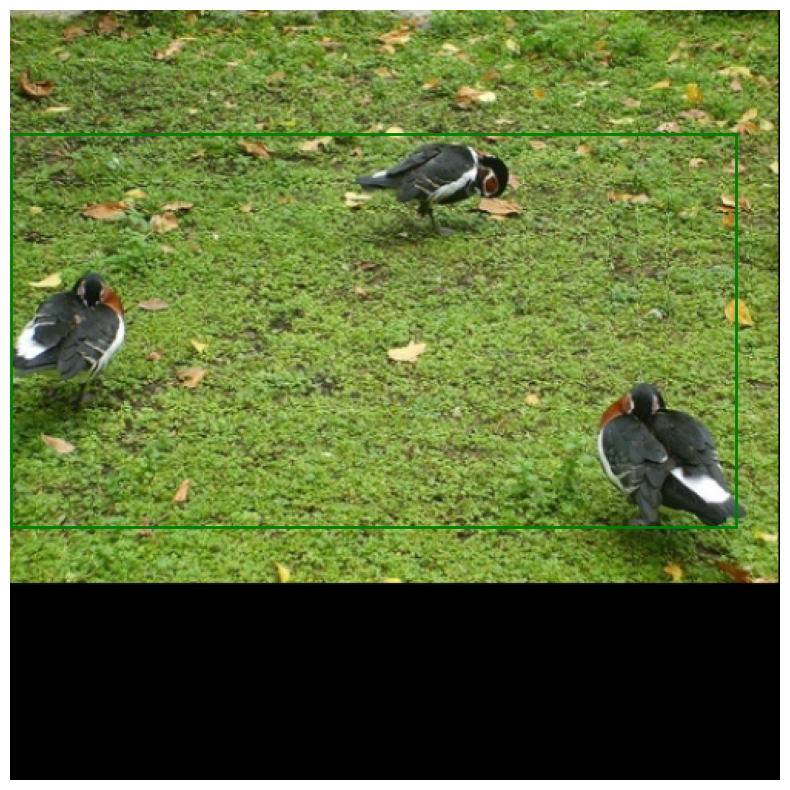

1000


In [8]:
import numpy as np
box_list = []
# print(fssmask_list[363])
for i in range(num_files):
    im = fssmask_list[i]
    # Segmentation color value (in Blender this is likely your pass index)
    seg_value = 1
    if im is not None:
        np_seg = np.array(im)
        segmentation = np.where(np_seg == seg_value)
        # Bounding Box
        bbox = 0, 0, 0, 0
        if len(segmentation) != 0 and len(segmentation[1]) != 0 and len(segmentation[0]) != 0:
            x_min = int(np.min(segmentation[1]))
            x_max = int(np.max(segmentation[1]))
            y_min = int(np.min(segmentation[0]))
            y_max = int(np.max(segmentation[0]))
            # bbox = x_min, y_min, x_max, y_max
            box_list.append([x_min, y_min, x_max, y_max])
        else:
            box_list.append([0, 0, 20, 20])

# print(bbox)
plt.figure(figsize=(10, 10))
plt.imshow(image_list[60]) #fssmask_list,image_list
bbox = np.array([[box_list[60][0],box_list[60][1],box_list[60][2],box_list[60][3]]])
for box in bbox:
    show_box(box, plt.gca())

plt.axis('off')
plt.show()
print(len(box_list))

In [9]:
#center

center_list = []
for i in range(num_files):
    # Calculate the moments of the binary image
    M = cv2.moments(fssmask_list[i])
    # Calculate the center coordinate of the binary mask
    x_c = M['m10'] / (M['m00'] + 1e-7)
    y_c = M['m01'] / (M['m00'] + 1e-7)
    center_list.append([x_c, y_c])
print(len(center_list))

1000


In [10]:
#center

point_list = []
label_list = []
for i in range(num_files):
    point = torch.tensor([[center_list[i]]], device=sam.device)
    point_list.append(point)
label = torch.tensor([[1]], device=sam.device)



In [11]:
#box
print(len(box_list))
boxes_list = []
for i in range(num_files):
    box = torch.tensor([[box_list[i]]], device=sam.device)
    boxes_list.append(box)

1000


Both images and prompts are input as PyTorch tensors that are already transformed to the correct frame. Inputs are packaged as a list over images, which each element is a dict that takes the following keys:
* `image`: The input image as a PyTorch tensor in CHW format.
* `original_size`: The size of the image before transforming for input to SAM, in (H, W) format.
* `point_coords`: Batched coordinates of point prompts.
* `point_labels`: Batched labels of point prompts.
* `boxes`: Batched input boxes.
* `mask_inputs`: Batched input masks.

If a prompt is not present, the key can be excluded.

In [12]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()
print(num_files)

1000


# generate SAM-Boosted Results

The confidence for sinle object EF-SAM are all 0.75.

In [13]:
batch_size = 1
new_output = []
for i in range(0, int(num_files/batch_size)):
    batched_input = []
    for p in range(batch_size):
        if (p + batch_size * i < num_files):
            inputi = { 'image': prepare_image(image_list[p + batch_size * i], resize_transform, sam),
                    'boxes': resize_transform.apply_boxes_torch(boxes_list[p + batch_size * i], image_list[p + batch_size * i].shape[:2]),
                    # 'point_coords': resize_transform.apply_coords_torch(point_list[p + batch_size * i], image_list[p + batch_size * i].shape[:2]),
                    # 'point_labels': label,
                    'original_size': image_list[0].shape[:2]
                    }
            batched_input.append(inputi)
    batched_output = sam(batched_input, multimask_output=False)
    for q in range(batch_size):
        for mask in batched_output[q]['masks']:
            save_mask = mask.cpu().numpy().transpose(1, 2, 0)
            save_mask= save_mask.view(np.uint8)
            cv2.imwrite('output/' + str(q + batch_size * i) + '.jpg', save_mask) 
            torch.save(mask, 'outputpt/' + str(q + batch_size * i) + '.pt')



# Using EF alogrithm to get final results.

You may need to change confidence to optimize the results. The mIoU results in the notebook are not accurate and only for reference, the final mIoU are evaluated by test_EF.sh

In [14]:
new_output_sam = []
num = 0
for i in range(num_files):
    image_t = cv2.imread('output/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)

    image_t_pt = torch.load('outputpt/' + str(i) + '.pt')

    intersection_judge = np.logical_and(image_t, fssmask_list[i])
    union_judge = np.logical_or(image_t, fssmask_list[i])
    confidence = np.sum(intersection_judge) / np.sum(union_judge)
    if confidence > 0.75:
        new_output_sam.append(image_t)
        cv2.imwrite('output2/' + str(i) + '.jpg', image_t*255)
        torch.save(image_t_pt, '../../BAM-main/output2pt/' + str(i) + '.pt')
        num+=1
    else:
        new_output_sam.append(fssmask_list[i])
        cv2.imwrite('output2/' + str(i) + '.jpg', fssmask_list[i]*255)
        torch.save(maskpt_list[i], '../../BAM-main/output2pt/' + str(i) + '.pt')
    

# Predifined evaluation, not final evaluation.
print(num) 
iou_score = 0
iou_score_new = 0
for i in range(num_files):
    intersection = np.logical_and(gt_list[i], fssmask_list[i])
    union = np.logical_or(gt_list[i], fssmask_list[i])
    iou_score += np.sum(intersection) / np.sum(union)
    
    intersection_new = np.logical_and(gt_list[i], new_output_sam[i]*255)
    union_new = np.logical_or(gt_list[i], new_output_sam[i]*255)
    iou_score_new += np.sum(intersection_new) / np.sum(union_new)
iou_score = iou_score / num_files
iou_score_new = iou_score_new / num_files
print("OriginalmIoU:",iou_score)
print("BoostedmIoU:",iou_score_new)

439
OriginalmIoU: 0.6115368821806035
BoostedmIoU: 0.6275019317808632
